In [1]:
from cmb_cpu import cap, measure, coords
import numpy as np
from numba import njit, prange

def anomaly(top_temp, bottom_temp):
    return (measure.std_t(top_temp) - measure.std_t(bottom_temp))**2

def calc_max_anomaly_dir(sim_temp, sim_pos, poles_coords:np.ndarray, cap_size = 90):
    all_dir_anomalies = np.zeros(len(poles_coords))
    for i in prange(len(poles_coords)):
        pole_lat, pole_lon = poles_coords[i]
        rotated_pos = coords.rotate_pole_to_north(pole_lat, pole_lon, sim_pos)
        top, bottom = cap.get_top_bottom_caps(sim_temp, rotated_pos, cap_size)
        top_temp, bottom_temp = top[0], bottom[0]
        all_dir_anomalies[i] = anomaly(top_temp, bottom_temp)
    index = np.argmax(all_dir_anomalies)
    return poles_coords[index]

def calc_all_size_anomaly_in_max_dir(sim_temp, sim_pos, poles_coords:np.ndarray, cap_sizes):
    all_size_anomalies = np.zeros(len(cap_sizes))
    max_anom_lat, max_anom_lon = calc_max_anomaly_dir(sim_temp, sim_pos, poles_coords)
    rotated_pos = coords.rotate_pole_to_north(max_anom_lat, max_anom_lon, sim_pos)
    for i in range(len(cap_sizes)):
        top, bottom = cap.get_top_bottom_caps(sim_temp, rotated_pos, cap_sizes[i])
        top_temp, bottom_temp = top[0], bottom[0]
        all_size_anomalies[i] = anomaly(top_temp, bottom_temp)
    return all_size_anomalies

In [4]:
poles_coords = np.loadtxt("./input/icosphere_verts_lat_lon.txt")
cap_sizes = np.arange(10, 180, 10)

n_sim = 1000
n_angles = len(cap_sizes)

sim_anomalies = np.zeros((n_sim, n_angles))
errors_of_anomaly_vs_size = np.zeros((len(cap_sizes), 3))
errors_of_anomaly_vs_size[:,0] = cap_sizes

for i in range(0,n_sim):
    path_sim_pos  = "./simulation_data/sim{:05}_pos.txt".format(i)
    path_sim_temp = "./simulation_data/sim{:05}_temp.txt".format(i)
    sim_pos = np.loadtxt(path_sim_pos)
    sim_temp = np.loadtxt(path_sim_temp)
    sim_temp *= 10**6
    sim_anomalies[i] = calc_all_size_anomaly_in_max_dir(sim_temp, sim_pos, poles_coords, cap_sizes)

for i, angle in enumerate(cap_sizes):
    errors_of_anomaly_vs_size[i, 2] = np.std(sim_anomalies[:, i])
    errors_of_anomaly_vs_size[i, 1] = np.mean(sim_anomalies[:, i])

np.savetxt("./output/errors_of_anomaly_vs_size.txt", errors_of_anomaly_vs_size)
np.savetxt("./output/sim_anomalies_vs_capangle.txt", sim_anomalies)

In [6]:
# CMB

sky_temp = np.loadtxt("./input/cmb64_temp.txt")
sky_temp *= 10**6

sky_pos = np.loadtxt("./input/cmb64_pos.txt")
lat, lon = -20, 221
sky_pos = coords.rotate_pole_to_north(lat, lon, sky_pos)

cap_angles = np.arange(10, 180, 10)
n_samples = 64 * 3

X2 = np.zeros(len(cap_angles))

top, bottom = cap.get_top_bottom_caps(sky_temp, sky_pos,10)

for i, ca in enumerate(cap_angles):
    top, bottom = cap.get_top_bottom_caps(sky_temp, sky_pos, ca)
    t_c = measure.std_t(top[0])
    b_c = measure.std_t(bottom[0])
    X2[i] = (t_c - b_c)**2

<ErrorbarContainer object of 3 artists>

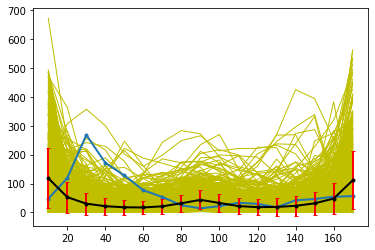

In [7]:
import matplotlib.pyplot as plt

# all simulations
for sim_data in sim_anomalies:
    plt.plot(cap_angles, sim_data, lw=1, color='y')

sim_anomaly = np.loadtxt("./output/errors_of_anomaly_vs_size.txt")
means   = sim_anomaly[:,1]
errors  = sim_anomaly[:,2]

# sky
plt.plot(cap_angles, X2, marker = '.', lw=2)
# simulation mean
plt.errorbar(cap_angles, means, errors, marker = '.', color='k', ecolor='red', lw=2, capsize=2, capthick=1)
